# Delay model and parameter inference for Bheda et al.

We try to find parameters for a simple stochastic delay model that describe the data for WT and the Elp6 mutatnt strain. Let's first import pyabc and other necessary packages.

## Imports

In [1]:
import pyabc
import datetime
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as st
import tempfile
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pyabc import (ABCSMC,
                   RV, Distribution,
                   MedianEpsilon,
                   LocalTransition)
import scipy as sp

## Data

We read in the data that is plotted in Fig. 4 in the manuscript

In [5]:
r1=pd.read_excel("delays_RD.xlsx")
r1.head()

,WT M2 Delay,elp6 M2 Delay,WT M2D2 RD,elp6 M2D2 RD
0,12.0,15.0,0.454545,0.000000
1,105.0,24.0,0.076923,0.040000
2,18.0,9.0,0.591837,0.310345
3,24.0,18.0,0.373134,0.452055
4,12.0,9.0,0.363636,0.200000


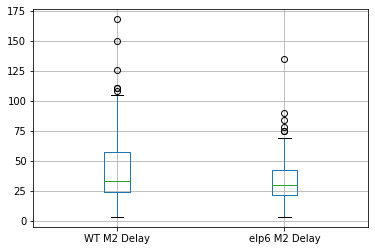

In [6]:
r1.boxplot(column=['WT M2 Delay','elp6 M2 Delay'])

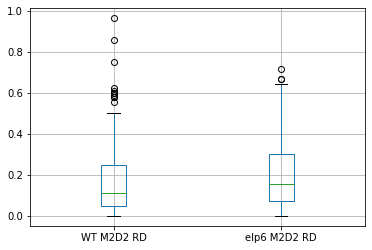

In [7]:
r1.boxplot(column=['WT M2D2 RD','elp6 M2D2 RD'])

In [8]:
r2=r1.values

In [9]:
r2.shape 

(272, 4)

In [10]:
# define data here
s1=r2[:,0]
s2=r2[:,1]
s3=r2[:,2]
s4=r2[:,3]

data={'delays_WT': s1[~np.isnan(s1)], 'delays_E6': s2[~np.isnan(s2)], 'reldifs_WT': s3[~np.isnan(s3)], 'reldifs_E6': s4[~np.isnan(s4)]}

we determine the number of values for WT and Elp6

In [11]:
nVec= {'delays_WT': data['delays_WT'].shape[0], 
       'delays_E6': data['delays_E6'].shape[0], 
       'reldifs_WT': data['reldifs_WT'].shape[0], 
       'reldifs_E6': data['reldifs_E6'].shape[0]
      }

In [12]:
nVec

{'delays_WT': 161, 'delays_E6': 121, 'reldifs_WT': 272, 'reldifs_E6': 245}

## Delay model definition

we model the delays with a Gamma distribution, once for WT, once for Elp6. 
The Gamma distribution has two parameters: shape and scale.
(If shape is a natural number, the Gamma distribution is called an Erlang distribution.)
Thus, our model has four parameters: two for WT, two for Elp6. 

In [15]:
def model(parameter):
    # delays: simple, draw from gamma
    delaysWT = np.random.gamma(parameter['shape_WT'], parameter['scale_WT'], nVec['delays_WT'])
    delaysE6 = np.random.gamma(parameter['shape_E6'], parameter['scale_E6'], nVec['delays_E6'])
    
    # relative difference WT: draw mother M2 and daughter D2 and calc rel difference
    differencesWT = np.random.randn(nVec['reldifs_WT']) ## initialize vector
    for x in np.nditer(differencesWT,op_flags=['readwrite']):
        M2=np.random.gamma(parameter['shape_WT'],parameter['scale_WT'], 1)
        D2=np.random.gamma(parameter['shape_WT'],parameter['scale_WT'], 1)
        x[...]= abs(M2 - D2)/np.mean(np.concatenate([M2, D2]))
        
    # relative difference: draw mother M2 and daughter D2 and calc rel difference
    differencesE6 = np.random.randn(nVec['reldifs_E6']) ## initialize vector
    for x in np.nditer(differencesE6,op_flags=['readwrite']):
        M2=np.random.gamma(parameter['shape_E6'],parameter['scale_E6'], 1)
        D2=np.random.gamma(parameter['shape_E6'],parameter['scale_E6'], 1)
        x[...]= abs(M2 - D2)/np.mean(np.concatenate([M2, D2]))
        

    return {'delays_WT': delaysWT, 'delays_E6': delaysE6, 'reldifs_WT': differencesWT, 'reldifs_E6': differencesE6}
model

<function __main__.model(parameter)>

We define the prior to be the same for WT and Elp6

In [17]:
shapeMin=1;
shapeMax=20;
scaleMin=.1;
scaleMax=15.;

prior = Distribution(
    shape_WT = RV("uniform", shapeMin, shapeMax), 
    scale_WT = RV("uniform", scaleMin, scaleMax),
    shape_E6 = RV("uniform", shapeMin, shapeMax),
    scale_E6 = RV("uniform", scaleMin, scaleMax))
prior

<Distribution 'scale_E6', 'scale_WT', 'shape_E6', 'shape_WT'>

## Run pyABC

pyABC (https://pyabc.readthedocs.io/en/latest/index.html) is a great method to fit parameters without having to specify the likelihood function. All you need is a distance function between data and model that is minimized. We define our distance fuction as follows, normalizing terms to push them on the same order of magnitude and thus weight them equally during optimization.

In [18]:
def distance(sim, dat): 
    d1 = sp.absolute((sp.mean(sim['delays_WT'])-sp.mean(dat['delays_WT']))/sp.mean(dat['delays_WT']))
    d2 = sp.absolute((sp.var(sim['delays_WT'])-sp.var(dat['delays_WT']))/sp.var(dat['delays_WT']))
    d3 = sp.absolute((sp.mean(sim['reldifs_WT'])-sp.mean(dat['reldifs_WT']))/sp.var(dat['reldifs_WT'])/sp.sqrt(nVec['reldifs_WT']))
    d4 = sp.absolute((sp.var(sim['reldifs_WT'])-sp.var(dat['reldifs_WT']))/sp.sqrt(nVec['reldifs_WT']))
    
    e1 = sp.absolute((sp.mean(sim['delays_E6'])-sp.mean(dat['delays_E6']))/sp.mean(dat['delays_E6']))
    e2 = sp.absolute((sp.var(sim['delays_E6'])-sp.var(dat['delays_E6']))/sp.var(dat['delays_E6']))
    e3 = sp.absolute((sp.mean(sim['reldifs_E6'])-sp.mean(dat['reldifs_E6']))/sp.var(dat['reldifs_E6'])/sp.sqrt(nVec['reldifs_E6']))
    e4 = sp.absolute((sp.var(sim['reldifs_E6'])-sp.var(dat['reldifs_E6']))/sp.sqrt(nVec['reldifs_E6']))
    
    return d1+d2+d3+d4+e1+e2+e3+e4

In [20]:
abc = pyabc.ABCSMC(model, prior, distance)

In [21]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))

In [22]:
abc.new(db_path, data) 

INFO:History:Start <ABCSMC(id=4, start_time=2019-08-29 16:49:16.602847, end_time=None)>


4

In [23]:
history = abc.run(minimum_epsilon=.1, max_nr_populations=10)

INFO:Epsilon:initial epsilon is 5.209504333980162
INFO:ABC:t:0 eps:5.209504333980162
INFO:ABC:t:1 eps:3.7702476833206213
INFO:ABC:t:2 eps:3.2305104043338586
INFO:ABC:t:3 eps:2.8147800150526128
INFO:ABC:t:4 eps:2.5888804395738507
INFO:ABC:t:5 eps:2.431648598597435
INFO:ABC:t:6 eps:2.317055725605101
INFO:ABC:t:7 eps:2.150816558141035
INFO:ABC:t:8 eps:2.1150214632344055
INFO:ABC:t:9 eps:2.0737398477919826
INFO:History:Done <ABCSMC(id=4, start_time=2019-08-29 16:49:16.602847, end_time=2019-08-29 16:57:51.794919)>


In [26]:
history is abc.history

True

In [27]:
history

### Analysis

Now lets look into the parameter posteriors

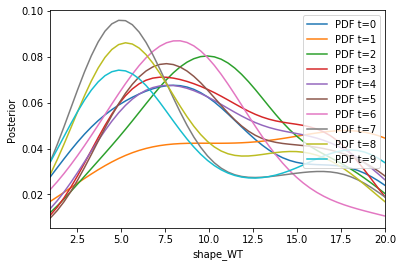

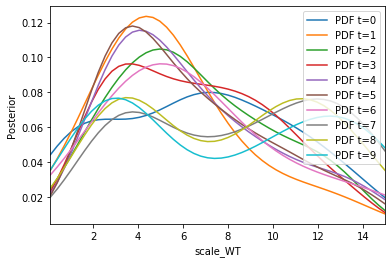

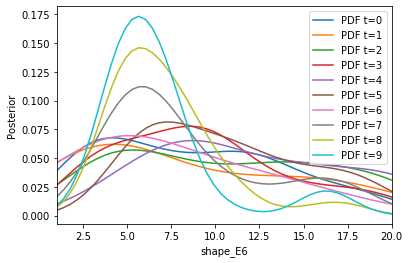

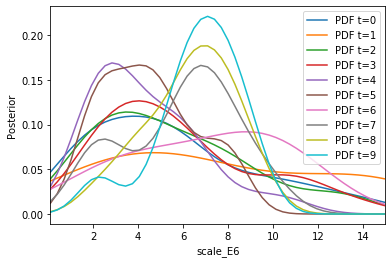

In [28]:
fig, ax = plt.subplots()
for t in range(history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df, w,
        xmin=shapeMin, xmax=shapeMax,
        x="shape_WT", ax=ax,
        label="PDF t={}".format(t))
ax.legend();

fig, ax = plt.subplots()
for t in range(history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df, w,
        xmin=scaleMin, xmax=scaleMax,
        x="scale_WT", ax=ax,
        label="PDF t={}".format(t))
ax.legend();

fig, ax = plt.subplots()
for t in range(history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df, w,
        xmin=shapeMin, xmax=shapeMax,
        x="shape_E6", ax=ax,
        label="PDF t={}".format(t))
ax.legend();

fig, ax = plt.subplots()
for t in range(history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df, w,
        xmin=scaleMin, xmax=scaleMax,
        x="scale_E6", ax=ax,
        label="PDF t={}".format(t))
ax.legend();

name
scale_E6    6.987494
scale_WT    8.289359
shape_E6    5.759310
shape_WT    6.558135
dtype: float64

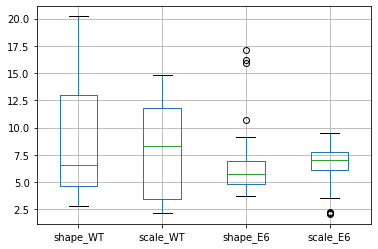

In [29]:
df.boxplot(column=['shape_WT','scale_WT','shape_E6','scale_E6'])
df.median()

We find that while the scale is similar, the shape is estimated smaller for Elp6

### Compare to simulated data

Lets check if the parameters fit to the data

In [30]:
df.head()

name,scale_E6,scale_WT,shape_E6,shape_WT
id,,,,
7505,6.423520,2.548652,6.227602,16.951566
7506,7.778780,3.563077,5.587246,11.870002
7507,6.868602,3.121468,6.726806,14.803847
7508,8.698720,5.045974,4.638779,9.013868
7509,7.948014,2.844540,4.778801,15.402049


In [31]:
myParams=pd.DataFrame({"shape_WT": [df.median()[3]],"scale_WT": [df.median()[1]], 'shape_E6': [df.median()[2]], 'scale_E6': [df.median()[0]]})
myParams

,shape_WT,scale_WT,shape_E6,scale_E6
0,6.558135,8.289359,5.75931,6.987494


In [32]:
sim=model(myParams)

Text(0, 0.5, 'Density')

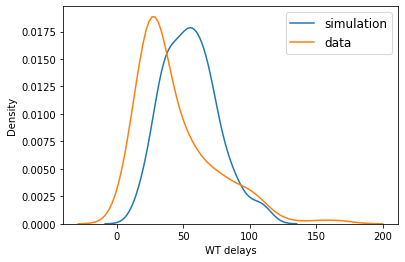

In [33]:
sns.distplot(sim['delays_WT'],hist=False,kde=True,label="simulation")
sns.distplot(data['delays_WT'],hist=False,kde=True,label="data")
plt.legend(prop={'size': 12})
plt.xlabel('WT delays')
plt.ylabel('Density') 

Text(0, 0.5, 'Density')

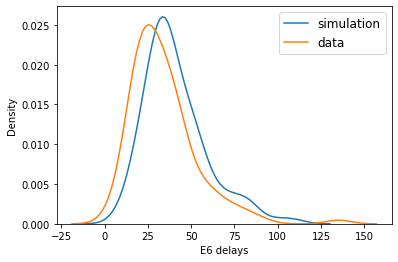

In [34]:
sns.distplot(sim['delays_E6'],hist=False,kde=True,label="simulation")
sns.distplot(data['delays_E6'],hist=False,kde=True,label="data")
plt.legend(prop={'size': 12})
plt.xlabel('E6 delays')
plt.ylabel('Density') 

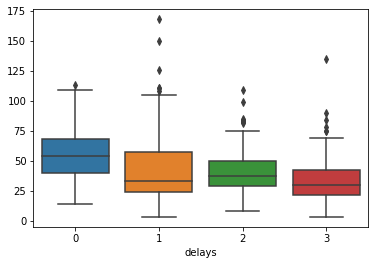

In [35]:
sns.boxplot(data=[sim['delays_WT'],data['delays_WT'],sim['delays_E6'],data['delays_E6']]).set(xlabel='delays')
plt.show()

Text(0, 0.5, 'Density')

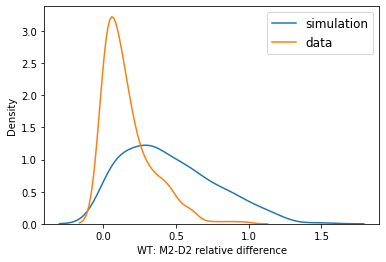

In [36]:
sns.distplot(sim['reldifs_WT'],hist=False,kde=True,label="simulation")
sns.distplot(data['reldifs_WT'],hist=False,kde=True,label="data")
plt.legend(prop={'size': 12})
plt.xlabel('WT: M2-D2 relative difference')
plt.ylabel('Density') 

Text(0, 0.5, 'Density')

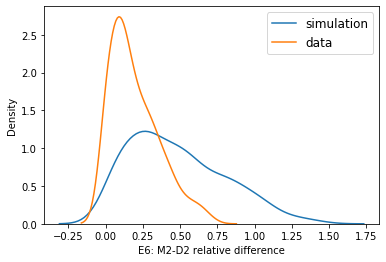

In [37]:
sns.distplot(sim['reldifs_E6'],hist=False,kde=True,label="simulation")
sns.distplot(data['reldifs_E6'],hist=False,kde=True,label="data")
plt.legend(prop={'size': 12})
plt.xlabel('E6: M2-D2 relative difference')
plt.ylabel('Density') 

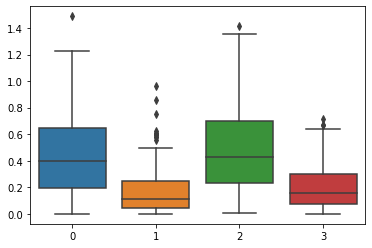

In [38]:
sns.boxplot(data=[sim['reldifs_WT'],data['reldifs_WT'],sim['reldifs_E6'],data['reldifs_E6']])

### In terms of an Erlang distribution

Lets now use an Erlang distriubtion by making the shape parameter natural numbers

In [39]:
myParams=pd.DataFrame({"shape_WT": [10.],"scale_WT": [5.], 'shape_E6': [6.], 'scale_E6': [5.]})
myParams

,shape_WT,scale_WT,shape_E6,scale_E6
0,10.0,5.0,6.0,5.0


In [42]:
sim=model(myParams)

Text(0, 0.5, 'Density')

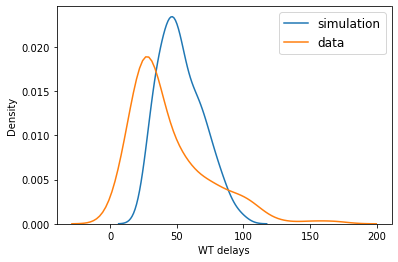

In [43]:
sns.distplot(sim['delays_WT'],hist=False,kde=True,label="simulation")
sns.distplot(data['delays_WT'],hist=False,kde=True,label="data")
plt.legend(prop={'size': 12})
plt.xlabel('WT delays')
plt.ylabel('Density') 

Text(0, 0.5, 'Density')

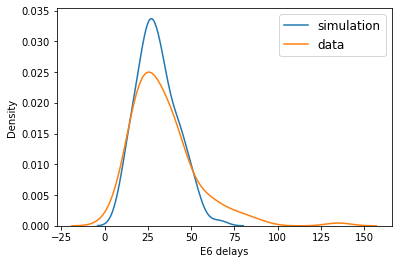

In [44]:
sns.distplot(sim['delays_E6'],hist=False,kde=True,label="simulation")
sns.distplot(data['delays_E6'],hist=False,kde=True,label="data")
plt.legend(prop={'size': 12})
plt.xlabel('E6 delays')
plt.ylabel('Density') 

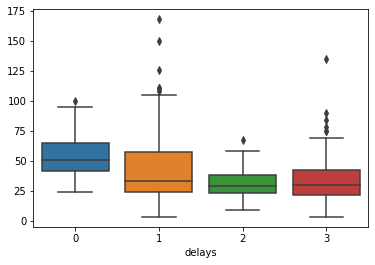

In [45]:
sns.boxplot(data=[sim['delays_WT'],data['delays_WT'],sim['delays_E6'],data['delays_E6']]).set(xlabel='delays')
plt.show()

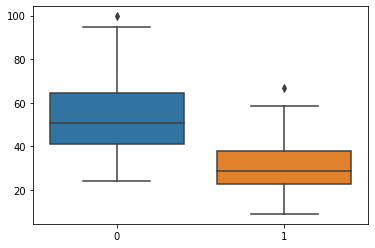

In [46]:
plot=sns.boxplot(data=[sim['delays_WT'], sim['delays_E6']])
fig=plot.get_figure()

In [47]:
fig.savefig("delays.pdf")

Text(0, 0.5, 'Density')

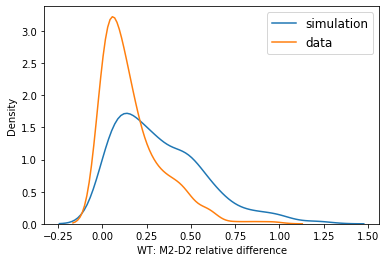

In [48]:
sns.distplot(sim['reldifs_WT'],hist=False,kde=True,label="simulation")
sns.distplot(data['reldifs_WT'],hist=False,kde=True,label="data")
plt.legend(prop={'size': 12})
plt.xlabel('WT: M2-D2 relative difference')
plt.ylabel('Density') 

Text(0, 0.5, 'Density')

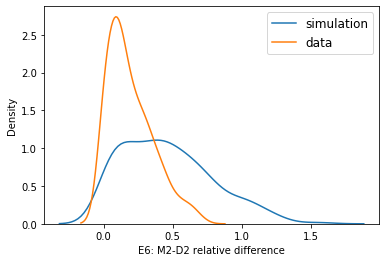

In [49]:
sns.distplot(sim['reldifs_E6'],hist=False,kde=True,label="simulation")
sns.distplot(data['reldifs_E6'],hist=False,kde=True,label="data")
plt.legend(prop={'size': 12})
plt.xlabel('E6: M2-D2 relative difference')
plt.ylabel('Density') 

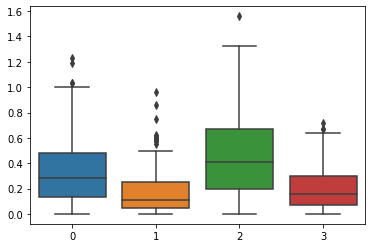

In [50]:
sns.boxplot(data=[sim['reldifs_WT'],data['reldifs_WT'],sim['reldifs_E6'],data['reldifs_E6']])

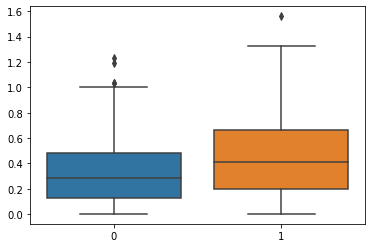

In [51]:
plot=sns.boxplot(data=[sim['reldifs_WT'], sim['reldifs_E6']])
fig=plot.get_figure()